# Problem Statement
Consider the samples from the World Wide Web that are provided in the data sets for Chapter 5 of LNR. Choose one of those samples and compute its degree distribution.  Use that to choose one of the evolving network models we studied in this module and proceed to fit that model to the sample data you chose.  

Now construct a subsample of no more than $N$ nodes, stipulating that two nodes in the subsample are connected if and only if the distance between them in the original sample was no more than $D$.  Perform the same analysis as above.  

What is the uncertainty of your model choice and parameter estimates?  How does the accuracy of your analysis improve as $N$ and $D$ increase?  How large do they need to be for your model choice and parameter estimates to be robust?


# Initialization and Setup

In [64]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy.optimize
import random
import collections
from tqdm import tqdm
import time

In [2]:
# Global constants
N = 325729
K = 1469680
file_name = "./www/web-NotreDame.net"

In [3]:
# Importing dataset as an edge list (note the dataset is directed and unweighted)
# Read data from `file_name` while calculating degrees
E = np.zeros((K,2))

with open(file_name, "r") as data_file:
    for it, line in enumerate(data_file.readlines()):
        tail, head = [int(k) for k in line.split()]
        E[it,0] = tail
        E[it,1] = head

# Relabel edges in storage from 0 to 875712, inclusive
_labels = dict(zip(np.sort(np.unique(E)), range(len(np.unique(E)))))
_relabel = np.vectorize(lambda index: _labels[index])
E = _relabel(E)

G = nx.DiGraph(tuple(map(tuple, E)))

In [4]:
# Calculate degrees of nodes in network
D_in = np.zeros(N)
D_out = np.zeros(N)

for row in E:
    D_out[row[0]] += 1
    D_in[row[1]] += 1

In [5]:
# Note <k^{in}> = <k^{out}> = k_avg.
k_avg = np.average(D_in)

# Visualizing in- and out-degree distributions

In [6]:
k_min = 1 # ignore nodes with degree less than k_min

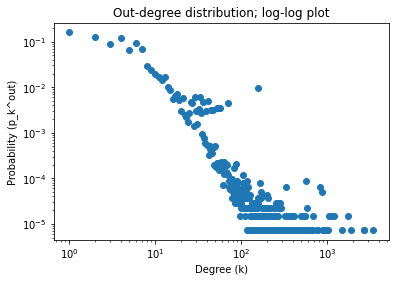

In [7]:
degrees_out, frequencies_out = np.unique(D_out[D_out >= k_min], return_counts=True)
probabilities_out = frequencies_out * 1/(len(D_out) - np.count_nonzero(D_out < k_min))

plt.title("Out-degree distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Probability (p_k^out)")
plt.scatter(degrees_out, probabilities_out)
plt.show()

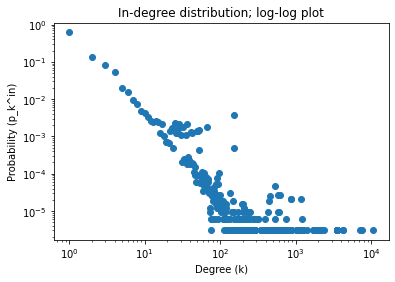

In [8]:
degrees_in, frequencies_in = np.unique(D_in[D_in >= k_min], return_counts=True)
probabilities_in = frequencies_in * 1/(len(D_in) - np.count_nonzero(D_in < k_min))

plt.title("In-degree distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Probability (p_k^in)")
plt.scatter(degrees_in, probabilities_in)
plt.show()

Clearly the data seems to behave as a power-law distribution $f(x)=cx^{-\gamma}$, so we now move to determine the values of these paramters by utilizing *cumulative distribution functions*. Note that the cumulative distribution function $P(k)$ of a power-law distribution $p(k)=ck^{-\gamma}$ is simply

$\displaystyle P(k)=c\int_k^{\infty} x^{-\gamma}\;dx=\frac{c}{\gamma-1}k^{-(\gamma-1)}$.

In [9]:
def pdf_to_cdf(pdf):
    return np.array([np.sum(pdf[k:]) for k in range(len(pdf))])

cumulative_probabilities_out = pdf_to_cdf(probabilities_out)
cumulative_probabilities_in = pdf_to_cdf(probabilities_in)

## Calculating $\gamma$ values
Through the code below we see that...
- $\gamma^{in}=2.43$ and $\gamma^{out}=3.97$ for the Google dataset.
- **$\gamma^{in}=2.444$ and $\gamma^{out}=2.696$ for the Notre Dame dataset.**

In [10]:
def power_law(x, gamma, c):
    return gamma * x + np.log(c) # Linear function when converted back to linear space becomes an exponential c * x^\gamma.

def power_law_fit(degrees_in, degrees_out, cumulative_probabilities_in, cumulative_probabilities_out):
    in_opt, in_cov = scipy.optimize.curve_fit(power_law, np.log(degrees_in), np.log(cumulative_probabilities_in))
    out_opt, out_cov = scipy.optimize.curve_fit(power_law, np.log(degrees_out), np.log(cumulative_probabilities_out))

    # We can recover coefficients:
    gamma_in = -(in_opt[0]-1)
    gamma_out = -(out_opt[0]-1)
    c_in = in_opt[1]*(-in_opt[0])
    c_out = out_opt[1]*(-out_opt[0])

    return gamma_in, gamma_out, c_in, c_out

gamma_in, gamma_out, c_in, c_out = power_law_fit(degrees_in, degrees_out, cumulative_probabilities_in, cumulative_probabilities_out)

print("IN gamma: {}, c: {}".format(gamma_in, c_in))
print("OUT gamma: {}, c: {}".format(gamma_out, c_out))

IN gamma: 2.443892490703324, c: 3.8986899478706127
OUT gamma: 2.696062541974041, c: 34.146250990394684


## Plotting cumulative distributions with corresponding functions

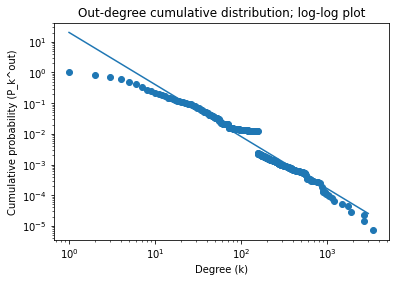

In [11]:
plt.title("Out-degree cumulative distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Cumulative probability (P_k^out)")
plt.scatter(degrees_out, cumulative_probabilities_out)
plt.plot(np.arange(1,3000,0.1), (c_out/(gamma_out-1))*np.arange(1,3000,0.1)**(-gamma_out+1))
plt.show()

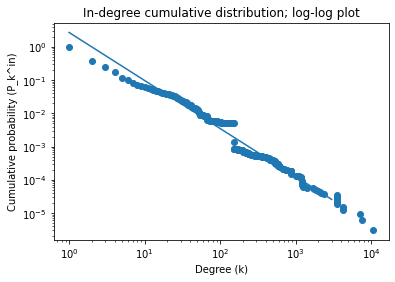

In [12]:
plt.title("In-degree cumulative distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Cumulative probability (P_k^in)")
plt.scatter(degrees_in, cumulative_probabilities_in)
plt.plot(np.arange(1,3000,0.1), (c_in/(gamma_in-1))*np.arange(1,3000,0.1)**(-gamma_in+1))
plt.show()

# Fitting the Web Graph (KRR) model

Note that in the KRR model, we find that by the rate equations, $\gamma^{in}=2+pa$ and $\gamma^{out}=1+q^{-1}+bpq^{-1}$, where $q=1-p$. We can determine $p=\langle k^{in}\rangle^{-1}=\langle k^{out}\rangle^-1$, and solve for $a$ and $b$ accordingly.

In [13]:
T = 1000 # time
p = 1/k_avg # probability of creating new node
a = (gamma_in-2)/p # tuning constant
b = (gamma_out-1-1/(1-p))/(p*1/(1-p)) # tuning constant
print("a: {}, b: {}".format(a,b))

def KRR_model(T, p, a, b):
    KRR_D_out = np.zeros((100000)) # arbitrary large size
    KRR_D_in = np.zeros((100000)) # arbitrary large size

    def in_degree_offset(node):
        return KRR_D_in[node] + a

    def out_degree_offset(node):
        return KRR_D_out[node] + b

    N = 2 # initial number of nodes
    G = nx.DiGraph([(0,1)]) # Initialize KRR model at time 0
    KRR_D_out[0] = 1 # set first edge
    KRR_D_in[1] = 1 # set first edge

    # This is O(T^3).
    for time in tqdm(range(T)):
        if(random.random() <= p):
            offset_degrees = np.array([in_degree_offset(k) for k in range(N)])
            target = np.random.choice(list(range(len(offset_degrees))), p=offset_degrees/np.sum(offset_degrees))

            N += 1
            G.add_edge(N, target)
            KRR_D_out[N] += 1
            KRR_D_in[target] += 1
        else:
            offset_degrees = np.array([[in_degree_offset(i)*out_degree_offset(j) for i in range(N)] for j in range(N)]) # columns are in-degree, rows are out-degree
            offset_degrees = offset_degrees.flatten()
            target = np.random.choice(list(range(len(offset_degrees))), p=offset_degrees/np.sum(offset_degrees))
            G.add_edge(target // N, target % N)
            KRR_D_out[target // N] += 1
            KRR_D_in[target % N] += 1
    
    return G

KRR_full = KRR_model(T, p, a, b)

100%|██████████| 1000/1000 [00:12<00:00, 81.59it/s]


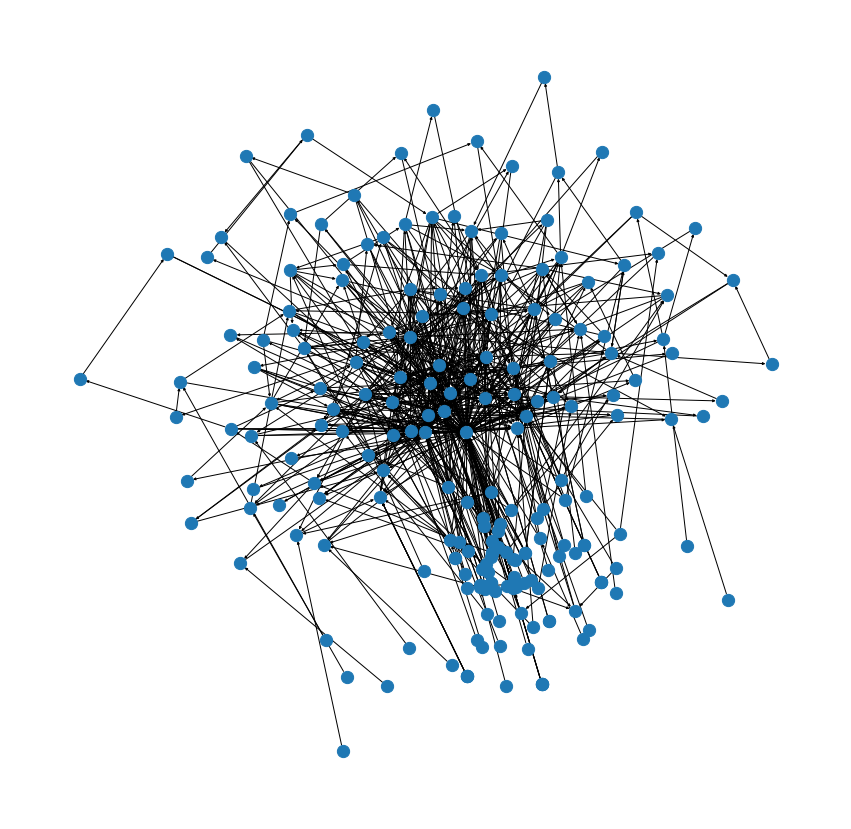

In [60]:
fig, ax = plt.subplots(figsize=(15,15))
nx.draw_kamada_kawai(KRR_full, ax=ax, arrowsize=5, node_size=150) # use Kamada-Kawai
plt.show()

In [15]:
# NetworkX degree histogram code adapted from https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree_histogram.html.

def cumulative_degree_probabilities(G): # G is a directed graph
    in_degree_sequence = sorted([d for n, d in G.in_degree()])  # degree sequence
    in_degree_count = collections.Counter(in_degree_sequence)
    in_deg, in_count = zip(*in_degree_count.items())
    in_prob = np.array(in_count) * 1/len(G.nodes)

    out_degree_sequence = sorted([d for n, d in G.out_degree()])  # degree sequence
    out_degree_count = collections.Counter(out_degree_sequence)
    out_deg, out_count = zip(*out_degree_count.items())
    out_prob = np.array(out_count) * 1/len(G.nodes)

    cumulative_in_prob = np.array([np.sum(in_prob[k:]) for k in range(len(in_prob))])
    cumulative_out_prob = np.array([np.sum(out_prob[k:]) for k in range(len(out_prob))])

    return in_deg, cumulative_in_prob, out_deg, cumulative_out_prob

KRR_in_deg, KRR_cumulative_in_prob, KRR_out_deg, KRR_cumulative_out_prob = cumulative_degree_probabilities(KRR_full)

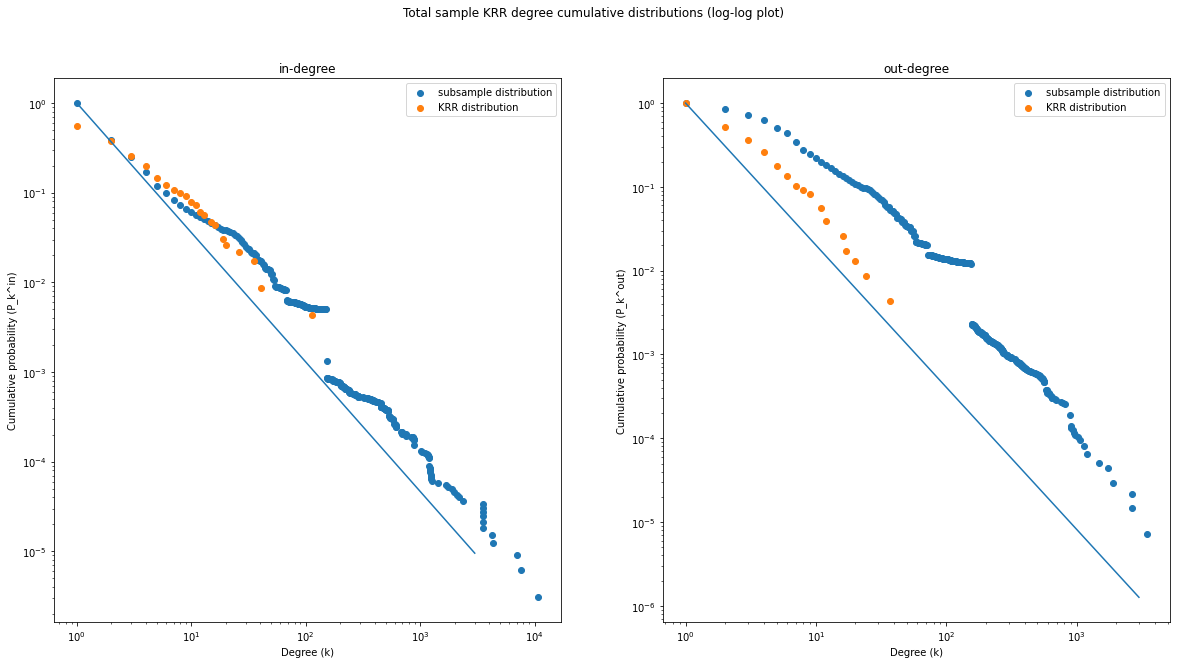

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

fig.suptitle("Total sample KRR degree cumulative distributions (log-log plot)")
ax1.set_title("in-degree")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Degree (k)")
ax1.set_ylabel("Cumulative probability (P_k^in)")
plt_subsample = ax1.scatter(degrees_in, cumulative_probabilities_in, label="subsample distribution")
plt_krr = ax1.scatter(KRR_in_deg, KRR_cumulative_in_prob, label="KRR distribution")
ax1.legend()
ax1.plot(np.arange(1,3000,0.1), np.arange(1,3000,0.1)**(-gamma_in+1))

ax2.set_title("out-degree")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Degree (k)")
ax2.set_ylabel("Cumulative probability (P_k^out)")
ax2.scatter(degrees_out, cumulative_probabilities_out, label="subsample distribution")
ax2.scatter(KRR_out_deg, KRR_cumulative_out_prob, label="KRR distribution")
ax2.legend()
ax2.plot(np.arange(1,3000,0.1), np.arange(1,3000,0.1)**(-gamma_out+1))

plt.show()

This shows that the KRR model seems to be working effectively, as its degree distributions match the exponent $\gamma$ of the original dataset.

# $(N,D)$ subsampling and the KRR model

Naive implementation of the max-distance condition in the problem. This runs too slowly to be practical.

```
def try_except(success, failure):
    try:
        return success()
    except:
        return failure()

for source in tqdm(sample): # O(N^2).
    for target in sample:
        distance_st = try_except(lambda: nx.shortest_path_length(G, source=source, target=target), lambda: np.inf)
        if(distance_st <= max_D and source != target):
            SG.add_edge(source, target)
```

In [18]:
def ND_subgraph(N_sample, D_max): # Creating sample subgraphs.
    sample = random.sample(list(range(N)), N_sample)
    SG = nx.DiGraph()
    SG.add_nodes_from(sample)

    SPL = {} # calculate shortest path lengths
    for i in tqdm(sample):
        SPL[i] = nx.shortest_path_length(G, source=i)

    for i in sample:
        for j in sample:
            if(j in SPL[i] and SPL[i][j] <= D_max):
                SG.add_edge(i,j)
    
    return SG, SPL

In [73]:
def graph_analysis(SG, T=1000):
    SG_deg_in, SG_cp_in, SG_deg_out, SG_cp_out = cumulative_degree_probabilities(SG)
    SG_gamma_in, SG_gamma_out, SG_c_in, SG_c_out = power_law_fit(SG_deg_in, SG_deg_out, SG_cp_in, SG_cp_out)

    SG_T = 2000 # time
    SG_p = 1/np.average([val for (node, val) in SG.degree()]) # probability of creating new node
    SG_a = (SG_gamma_in-2)/SG_p # tuning constant
    SG_b = (SG_gamma_out-1-1/(1-SG_p))/(SG_p*1/(1-SG_p)) # tuning constant

    print("gamma_in: {}\ngamma_out: {}\n".format(SG_gamma_in, SG_gamma_out))
    print("p: {}\na: {}\nb: {}".format(SG_p, SG_a, SG_b))
    time.sleep(0.5)

    SG_KRR = KRR_model(SG_T, SG_p, SG_a, SG_b)
    SG_KRR_deg_in, SG_KRR_cp_in, SG_KRR_deg_out, SG_KRR_cp_out = cumulative_degree_probabilities(SG_KRR)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    fig.suptitle("Subgraph 2 KRR degree cumulative distributions (log-log plot)")
    ax1.set_title("in-degree")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Degree (k)")
    ax1.set_ylabel("Cumulative probability (P_k^in)")
    plt_subsample = ax1.scatter(SG_deg_in, SG_cp_in, label="subsample distribution")
    plt_krr = ax1.scatter(SG_KRR_deg_in, SG_KRR_cp_in, label="KRR distribution")
    ax1.legend()
    ax1.plot(np.arange(1,3000,0.1), np.arange(1,3000,0.1)**(-SG_gamma_in+1))

    ax2.set_title("out-degree")
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_xlabel("Degree (k)")
    ax2.set_ylabel("Cumulative probability (P_k^out)")
    ax2.scatter(SG_deg_out, SG_cp_out, label="subsample distribution")
    ax2.scatter(SG_KRR_deg_out, SG_KRR_cp_out, label="KRR distribution")
    ax2.legend()
    ax2.plot(np.arange(1,3000,0.1), np.arange(1,3000,0.1)**(-SG_gamma_out+1))

    plt.show()

### $N=1000$, $D=3$

In [19]:
SG1, SG1_SPL = ND_subgraph(1000,3)

100%|██████████| 1000/1000 [01:22<00:00, 12.06it/s]


gamma_in: 2.914581331860927
gamma_out: 3.116191220462902

p: 0.2962085308056872
a: 3.087626576362489
b: 1.6520703398198548
100%|██████████| 2000/2000 [02:22<00:00, 14.01it/s]


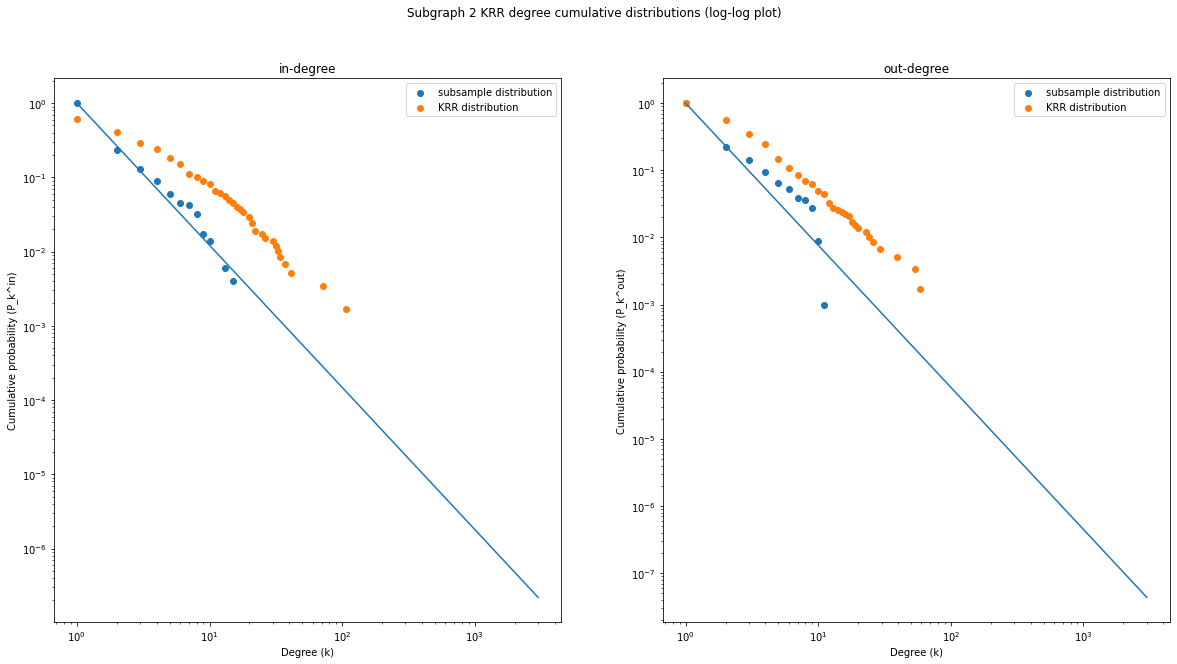

In [75]:
graph_analysis(SG1)

### $N=5000$, $D=4$

In [24]:
SG2, SG2_SPL = ND_subgraph(5000,4)

100%|██████████| 5000/5000 [06:58<00:00, 11.95it/s]


gamma_in: 2.5108700489869307
gamma_out: 2.5309301725450175

p: 0.054890767372927876
a: 9.307030552443903
b: 8.141555710880112
100%|██████████| 2000/2000 [00:07<00:00, 258.91it/s]


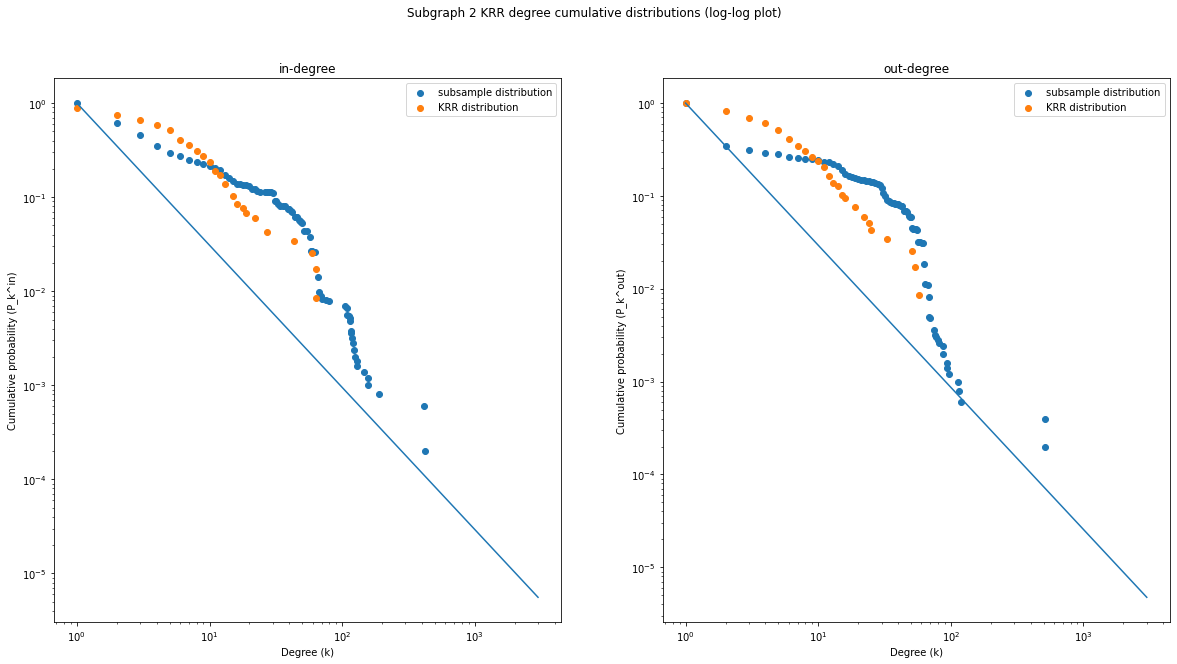

In [74]:
graph_analysis(SG2, T=2000)